Jupyter Notebook to load and plot the parcels simulation output

In [1]:
#load packages
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from netCDF4 import Dataset
import netCDF4 as nc4
import numpy as np
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import scipy.io
from scipy.io import loadmat
from scipy.stats import binned_statistic_2d


# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
#read in land feature for later
land_110m = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

# Set general font size
plt.rcParams['font.size'] = '16' 

Read in and print the variables in the netcdf file - you will need to amend the directory location to your home directory and the outfile name that you used in the parcels_run.py script

In [2]:
outfile=nc4.Dataset('/home/users/train023/Documents/CLASS_workshop/Parcels/lagran/data/output_5yrs.nc','r',format='NETCDF4')
print(outfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6/CF-1.7
    feature_type: trajectory
    ncei_template_version: NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh: spherical
    parcels_version: 2.4.2
    dimensions(sizes): trajectory(100), obs(370)
    variables(dimensions): float32 bathy(trajectory, obs), float64 lat(trajectory, obs), float64 lon(trajectory, obs), float32 mld(trajectory, obs), int32 obs(obs), float64 time(trajectory, obs), int64 trajectory(trajectory), float64 z(trajectory, obs)
    groups: 


Read in the variables in the file

.T transposes the shape of the variable which makes plotting easier

In [3]:
lat=outfile.variables['lat'][:,:].T #latitude in degrees 
lon=outfile.variables['lon'][:,:].T #longitude in degrees
depth=outfile.variables['z'][:,:].T #depth in meters
time=outfile.variables['time'][:,:].T #time in seconds
bathy=outfile.variables['bathy'][:,:].T #bathymetry depth in meters
mld=outfile.variables['mld'][:,:].T #along trajectory mixed layer depth in meters
obs=outfile.variables['obs'][:].T #number of outputted timesteps
traj=outfile.variables['trajectory'][:].T #trajectory number

Explore what the different variables look like by changing the var=XXX - if you pick a one dimensional variable you will need to change var[:,:] to var[:]

In [4]:
var=depth #change variable name here
print(var[2,0:100])
print(var.shape) #shape of the variables

var=mld #change variable name here
print(var[0:5,0:20])
print(var.shape) #shape of the variables

[197.9554221528815 201.58650279913672 203.42891528555356
 204.85636547923605 207.99740656739232 208.8474753600167 205.7669489698128
 203.49503989491495 204.13361387591067 204.3280094394504 202.1565900259361
 204.21423213724665 205.6362855983025 206.50074156510527 207.2406118568324
 204.24089569632997 201.06844523966174 202.77154761238307
 203.69181936584937 203.97365865401298 205.26859958745263
 205.30953072075135 204.84201243580173 204.6173623993127 201.8894729932981
 197.55770746744474 197.1511255090718 202.95550818013908
 204.81369997123693 204.4039014518603 206.3422247487324 206.50443727281527
 202.4663552268521 200.65782935382686 197.37382859166246
 195.60784089462686 198.42200993409733 202.69343450627275
 203.8698610916981 204.24387273783395 206.72489793068962
 208.09305167022103 201.1344945984547 198.17929883922716
 196.91123288616836 197.78257463894988 200.75108115703415
 201.20767399814667 202.11814535887243 202.47077747981166
 208.0471878147364 208.96464430261403 201.85591737

Let's convert the time variable into a more useful format as it's currently in seconds

In [5]:
time_days=time.copy()/86400 #number of seconds in a day # converting to days from start of simulation
print(time_days[:,0])
#but we have also divided the fill value of -9.22337204e+18 by 86400 - let's get rid of this
time_days[time_days==-106751991167300.64]=np.nan #replace with NaNs
print(time_days[:,0])

[0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 50.0 55.0 60.0 65.0 70.0
 75.0 80.0 85.0 90.0 95.0 100.0 105.0 110.0 115.0 120.0 125.0 130.0 135.0
 140.0 145.0 150.0 155.0 160.0 165.0 170.0 175.0 180.0 185.0 190.0 195.0
 200.0 205.0 210.0 215.0 220.0 225.0 230.0 235.0 240.0 245.0 250.0 255.0
 260.0 265.0 270.0 275.0 280.0 285.0 290.0 295.0 300.0 305.0 310.0 315.0
 320.0 325.0 330.0 335.0 340.0 345.0 350.0 355.0 360.0 365.0 370.0 375.0
 380.0 385.0 390.0 395.0 400.0 405.0 410.0 415.0 420.0 425.0 430.0 435.0
 440.0 445.0 450.0 455.0 460.0 465.0 470.0 475.0 480.0 485.0 490.0 495.0
 500.0 505.0 510.0 515.0 520.0 525.0 530.0 535.0 540.0 545.0 550.0 555.0
 560.0 565.0 570.0 575.0 580.0 585.0 590.0 595.0 600.0 605.0 610.0 615.0
 620.0 625.0 630.0 635.0 640.0 645.0 650.0 655.0 660.0 665.0 670.0 675.0
 680.0 685.0 690.0 695.0 700.0 705.0 710.0 715.0 720.0 725.0 730.0 735.0
 740.0 745.0 750.0 755.0 760.0 765.0 770.0 775.0 780.0 785.0 790.0 795.0
 800.0 805.0 810.0 815.0 820.0 825.0 830.0 835.0 

Plot the trajectory release grid

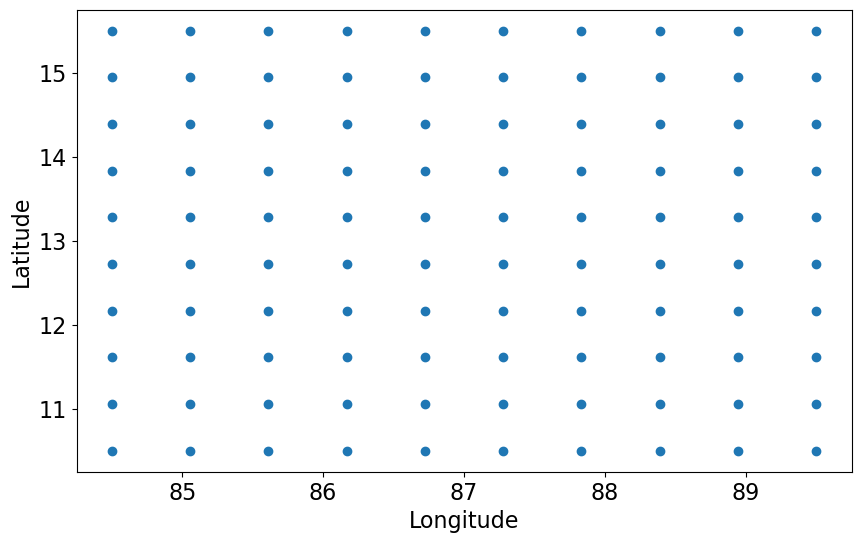

In [6]:
plt.figure()
plt.scatter(lon[0,:],lat[0,:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

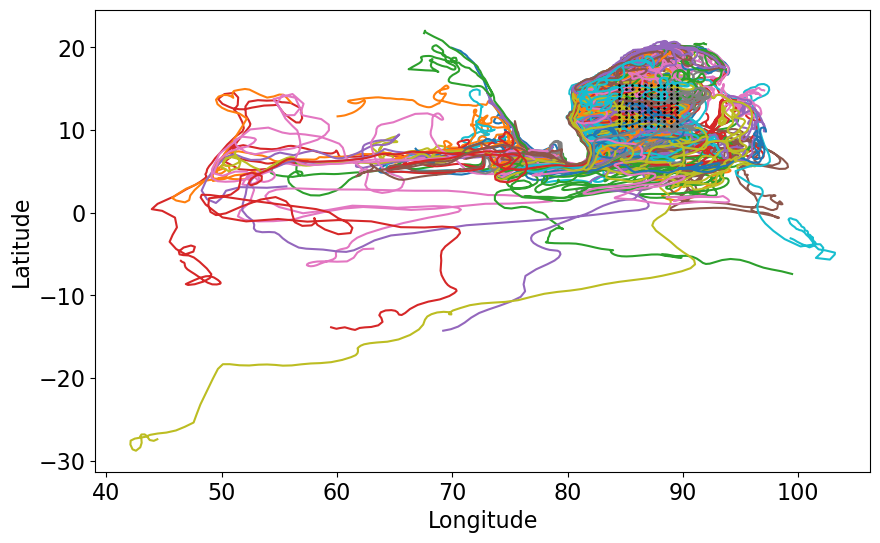

In [7]:
#the positive and negative longitude values are separated to avoid stripes along the plot if a trajectory crosses -180 to 180 or vice versa
lon_180_0=lon.copy()
lon_180_0[lon>0]=np.nan
lon_0_180=lon.copy()
lon_0_180[lon<0]=np.nan

plt.figure()
plt.plot(lon_180_0,lat,zorder=0) # plotting trajectory lon and lats
plt.plot(lon_0_180,lat,zorder=0) # plotting trajectory lon and lats
plt.scatter(lon[0,:],lat[0,:],c='k',s=0.9)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

Let's plot a map of trajectories - adjust the lon and lat range to zoom in to the correct area

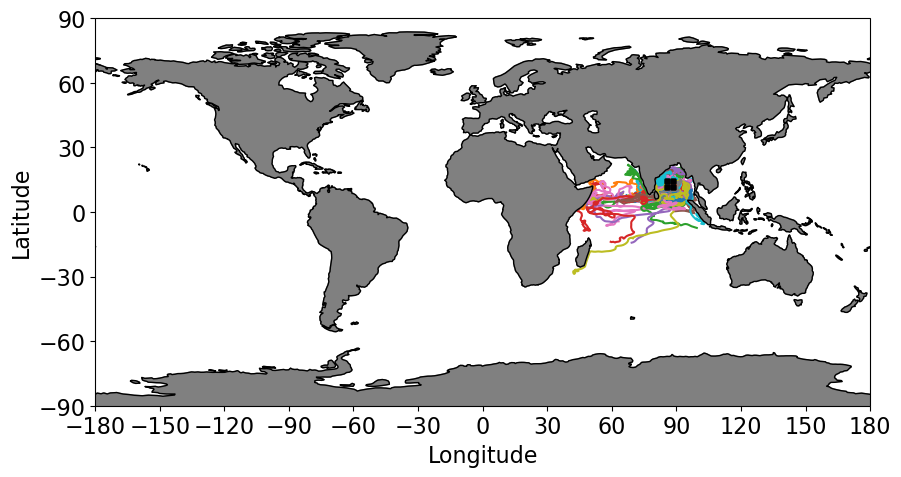

In [8]:
xmin=-180 #set minimum longitude limit
xmax=180 #set maximum longitude limit
ymin=-90 #set minimum latitude limit
ymax=90 #set maximum longitude limit
xint=30 #set xtick interval
yint=30 #set ytick interval



plt.figure()
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plot1 = ax1.plot(lon_180_0,lat,transform=ccrs.PlateCarree(),zorder=-1) # plotting trajectory lon and lats
plot2 = ax1.plot(lon_0_180,lat,transform=ccrs.PlateCarree(),zorder=-1) # plotting trajectory lon and lats
ax1.scatter(lon[0,:],lat[0,:],c='k',s=0.4)
ax1.add_feature(land_110m,facecolor='gray')
ax1.coastlines(resolution='110m')
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])
ax1.set_xticks(np.arange(xmin,xmax+0.5, step=xint))
ax1.set_yticks(np.arange(ymin, ymax+0.5, step=yint))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.savefig("graphs/new.png")
plt.show()
plt.close()

Plot showing how the depth of the trajectories change with time 

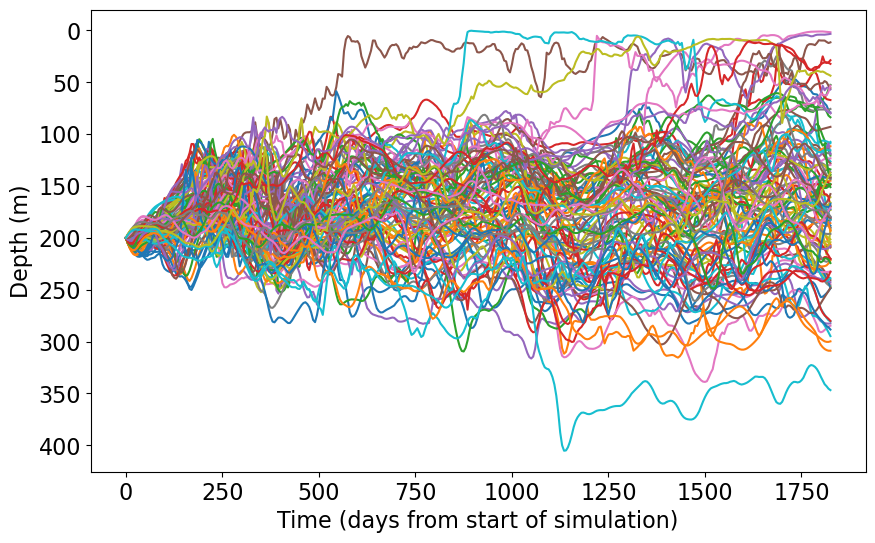

In [9]:
plt.figure()
plt.plot(time_days,depth)
plt.gca().invert_yaxis()
plt.xlabel('Time (days from start of simulation)')
plt.ylabel('Depth (m)')
plt.show()
plt.close()

Plot a heatmaps of the trajectory density - the warmer the colour the more trajectory timesteps that passed through that grid cell

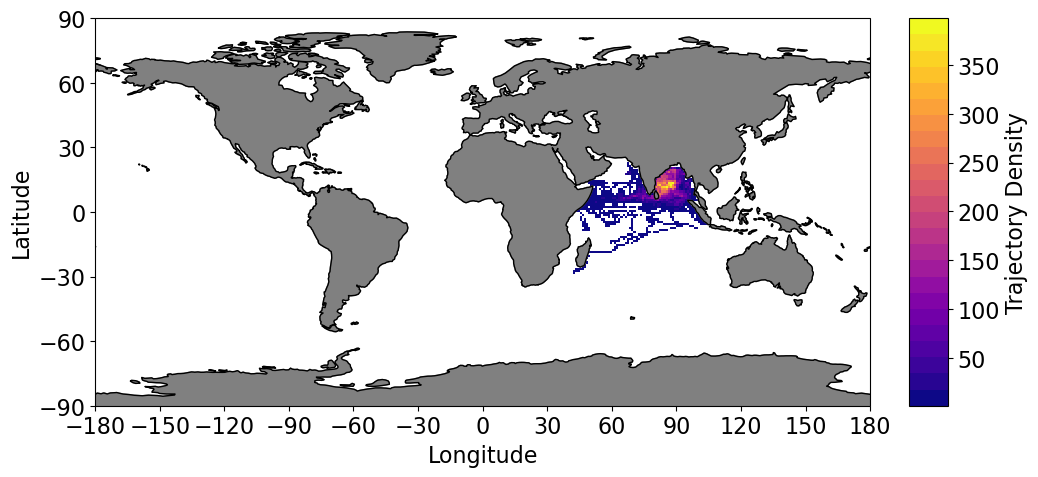

In [10]:
#create meshgrid and arrange data
xgrid=np.arange(-180,180.25,1) #change the final number to indicate grid resolution, 1=1 degree
ygrid=np.arange(-90,90.25,1) #change the final number to indicate grid resolution, 1=1 degree

#grid lon and lat and bin the data
X, Y= np.meshgrid(xgrid,ygrid)
histgrid, xgrid, ygrid= np.histogram2d(lon.flatten(),lat.flatten(), bins=(xgrid, ygrid))

#plot figure
plt.figure()
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
axins1 = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0)
cmap=cm.get_cmap("plasma",lut=24)
plot1=ax1.pcolormesh(X,Y,histgrid.T,cmap=cmap,vmin=1,transform=ccrs.PlateCarree())
plot1.cmap.set_under('w')
ax1.add_feature(land_110m,facecolor='gray')
ax1.coastlines(resolution='110m')
cb1=plt.colorbar(plot1,cax=axins1)
cb1.set_label('Trajectory Density')
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])
ax1.set_xticks(np.arange(xmin,xmax+0.5, step=xint))
ax1.set_yticks(np.arange(ymin, ymax+0.5, step=yint))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.show()
plt.close()



Sequestration Efficiency Calculations similar to Baker et al. (2022)

In [11]:
#create variable to indicate where the trajectory is within the MLD
reentrain=depth.copy()
reentrain[0,:]=np.nan
reentrain[depth>mld]=0 
reentrain[depth<mld]=1

#indicate which trajectories were reentrained into the mixed layer
reen_traj=np.nansum(reentrain,axis=0)
reen_traj[reen_traj>=1]=1

#calculate the sequestration efficiency of the simulation
seqeff=100-(np.nansum(reen_traj)/len(depth[0,:])*100)

#change YY to depth of particle release and change XX to length of simulation in years
print('Sequestration Efficiency (%) at YY m over timescales of XX years')
print(np.round(seqeff,2))

Sequestration Efficiency (%) at YY m over timescales of XX years
90.0


Let's check that the calculated sequestration efficiency seems correct but looking at the data - all dark blue plots == 100% sequestration efficiency, in plot b) all yellow markers at one timestep == 0% sequestration efficiency

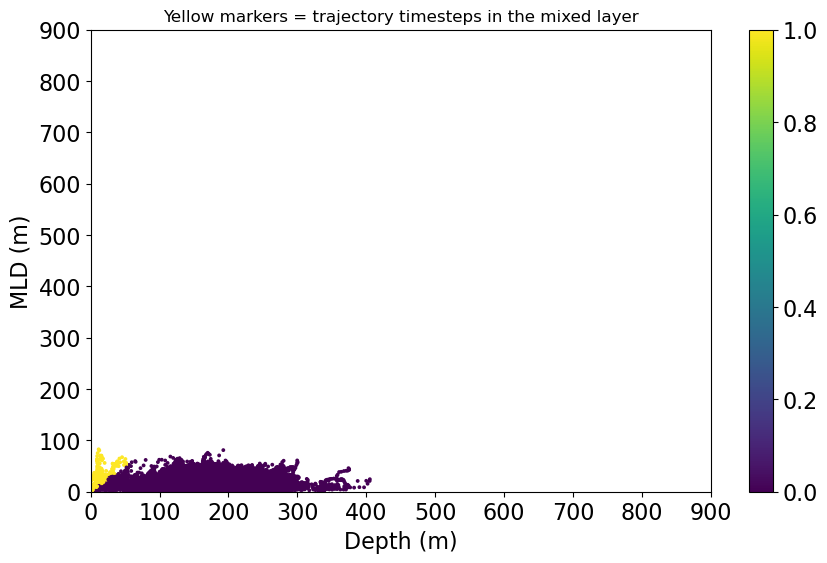

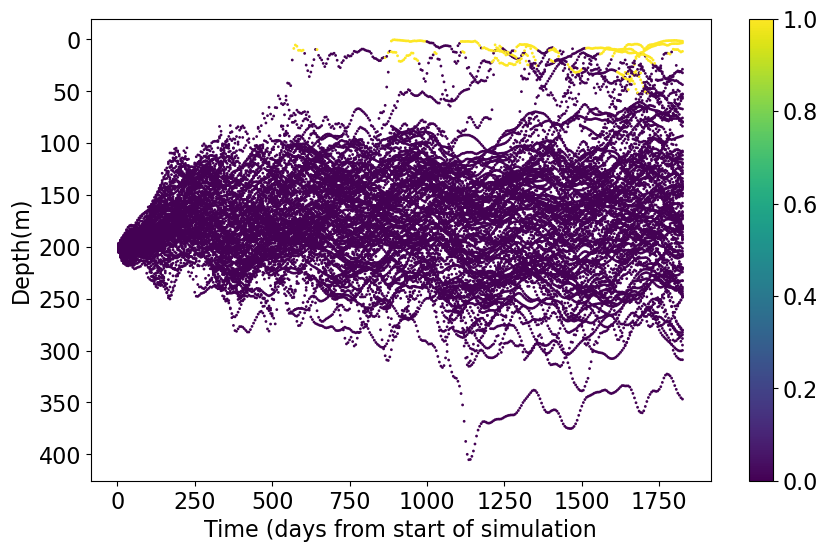

In [12]:
plt.figure()
plt.scatter(depth,mld,c=reentrain,s=3)
plt.xlim([0,900])
plt.ylim([0,900]) #you may need to expand these limits if the plot is empty
plt.colorbar()
plt.xlabel('Depth (m)')
plt.ylabel('MLD (m)')
plt.title('Yellow markers = trajectory timesteps in the mixed layer',fontsize=12)
plt.show()
plt.close()

plt.figure()
plt.scatter(time_days, depth,c=reentrain,s=1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('Time (days from start of simulation')
plt.ylabel('Depth(m)')
plt.show()
plt.close()

Plot a map of the spatial sequestration efficiency at the release location

In [13]:
#some calculations to get the gridded sequestration efficiency
reen_grid=reentrain.copy()
reen_lat=np.full([len(reen_grid[:,0]),len(reen_grid[0,:])],np.nan)
reen_lon=np.full([len(reen_grid[:,0]),len(reen_grid[0,:])],np.nan)

for i in range(0,len(reen_grid[0,:]),1):
    reen_first=0
    for j in range(0,len(reen_grid[:,0]),1):
        if reen_first==1 and reen_grid[j,i]==1:
            reen_grid[j,i]=0
            
        elif reen_first==0 and reen_grid[j,i]==1:
            reen_first=1
            reen_lat[j,i]=lat[0,i]
            reen_lon[j,i]=lon[0,i]
            
            
rel_lon=lon[0,:]
rel_lat=lat[0,:]
rel_traj=depth[0,:]
rel_traj[rel_traj>0]=1

xi = np.arange(-180,180.25,1)
yi = np.arange(-90,90.25,1)
#calculate how many retrained 
reen_sum=scipy.stats.binned_statistic_2d(reen_lon.flatten(), reen_lat.flatten(), reen_grid.flatten(), statistic='sum', bins=[xi,yi], range=None, expand_binnumbers=False).statistic
print('Number of trajectories reentrained into the mixed layer')
print(np.nansum(reen_sum))

rel_sum=scipy.stats.binned_statistic_2d(rel_lon.flatten(), rel_lat.flatten(), rel_traj.flatten(), statistic='sum', bins=[xi,yi], range=None, expand_binnumbers=False).statistic
print('Number of trajectories in the simulation')
print(np.nansum(rel_sum))

#calculate the gridded sequestration efficiency
seqeff_grid=100-((reen_sum/rel_sum)*100)
print(seqeff)

Number of trajectories reentrained into the mixed layer
10.0
Number of trajectories in the simulation
100.0
90.0


/tmp/ipykernel_2864/1524903278.py:35: RuntimeWarning: invalid value encountered in divide
  seqeff_grid=100-((reen_sum/rel_sum)*100)


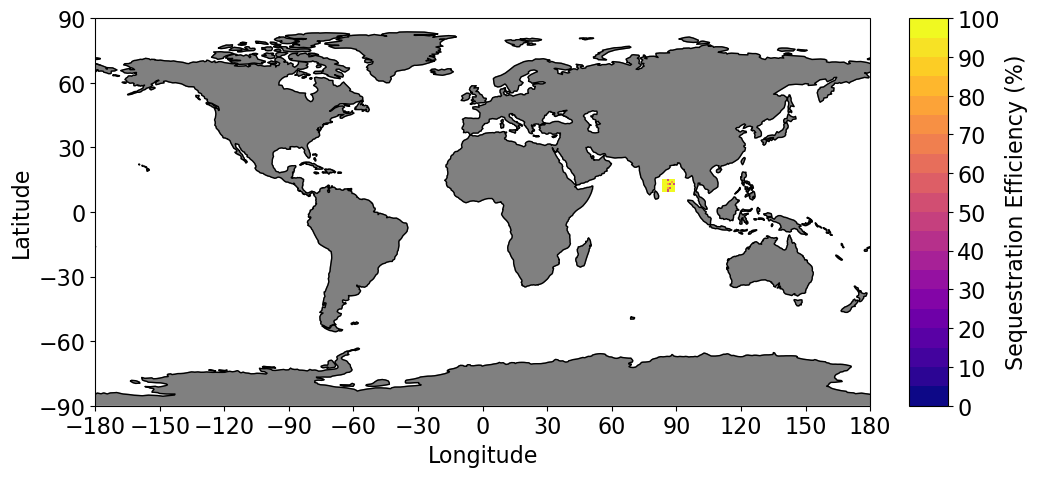

In [14]:
levls=np.linspace(0,100,11)
#plot figure
plt.figure()
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
axins1 = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0)
cmap=cm.get_cmap("plasma",lut=20)
plot1=ax1.pcolormesh(xi[0:len(xi)-1],yi[0:len(yi)-1],seqeff_grid.T,vmin=0,vmax=100,cmap=cmap,transform=ccrs.PlateCarree())
plot1.cmap.set_under('w')
ax1.add_feature(land_110m,facecolor='gray')
ax1.coastlines(resolution='110m')
cb1=plt.colorbar(plot1,cax=axins1,ticks=levls)
cb1.set_label('Sequestration Efficiency (%)')
ax1.set_ylim([ymin,ymax])
ax1.set_xlim([xmin,xmax])
ax1.set_xticks(np.arange(xmin,xmax+0.5, step=xint))
ax1.set_yticks(np.arange(ymin, ymax+0.5, step=yint))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.show()
plt.close()

Now switch back to the task sheet to run the trajectory_metrics.py script to calculate distances and speed

Keep exploring the simulation results by creating your own plots below... have fun!  

In [15]:
#make more plots here...